# Proximity tools

In this tutorial, you'll learn how to use [Xarray-Spatial's proximity toolset](https://xarray-spatial.org/user_guide/proximity.html) to measure distances between points. You'll analyze water level data for the Amazon rainforest around Oriximiná, Brazil, from the [European Commission Joint Research Centre's Global Surface Water Dataset](https://planetarycomputer-staging.microsoft.com/dataset/jrc-gsw).

Xarray-Spatial offers three proximity tools:
* [Proximity Distance](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Distance): for each point in the input raster, this tool calculates the distance to the nearest of a set of target points or source points.
* [Proximity Allocation](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Allocation): for each cell in the input raster, this tool identifies the nearest source or target point (the 'allocation' point).
* [Proximity Direction](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Direction): for each cell in the input raster, this tool returns the direction to the nearest source point (the 'allocation').

These proximity tools support the following three metrics to measure distances:
* [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance): a straight-line distance between two points
* [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry): a distance that considers obstacles in the path, also known as 'taxicab' metric
* [Great-circle distance](https://en.wikipedia.org/wiki/Great-circle_distance): a distance across the surface of a sphere instead of a plane

This tutorial walks you through:
1. [Loading and preparing](#Load-and-render-the-area-of-interest-data) the Global Surface Water Dataset
2. [Computing Proximity Distance](#Proximity-Distance): Analyze the Global Surface Water Dataset's Maximum Water Extent data to calculate proximity distances in relation to all points that were detected as water. 
3. [Computing Proximity Allocation](#Proximity-Allocation): Analyze the Global Surface Water Dataset's Occurrence data to calculate proximity allocations between areas of different water occurrences.
4. [Computing Proximity Direction](#Proximity-Direction): Analyze the Global Surface Water Dataset's Water Seasonality data to calculate the proximity direction of areas where surface water is present for more than three quarters of the year.

In [1]:
import copy

from pystac_client import Client
import rasterio
import rasterio.mask
import numpy as np
import pystac
import planetary_computer as pc
import stackstac

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

from xrspatial import proximity, allocation, direction

## Load and render the area of interest data

In this notebook, you'll analyze a small area in the Amazon rainforest located around Oriximiná, State of Pará, Brazil. The region of interest contains parts of the Amazon River, Trombetas River, and Paru de Oeste River. 

Use `pystac-client` to find all [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/overview.md#item-overview) covering that area:

In [2]:
bounds = [-57.151965, -2.130125, -55.710724, -1.179033]

catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")
jrc = catalog.search(collections=["jrc-gsw"], bbox=bounds)

items = list(jrc.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [3]:
item = items[0]
item

<Item id=60W_0Nv1_3_2020>

For this example, you'll analyze these three assets of the dataset: Maximum Water Extent, Water Occurrence, and Water Seasonality. Use [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html), to load the item data, select the desired assets, and crop it to our bounds of interest. All these three operations happen at the same time. See the [jrc-gsw example notebook](../datasets/jrc-gsw/jrc-gsw-example.ipynb) to learn more about how to use this dataset.

In [4]:
assets_of_interest = ["extent", "occurrence", "seasonality"]

data = stackstac.stack(
    [pc.sign(item).to_dict()],
    assets=assets_of_interest,
    bounds=bounds,
    chunksize=2000
).isel(time=0)

data

<xarray.DataArray 'stackstac-2701dad3e9581f1ea2662698d3663f6c' (band: 3, y: 3805, x: 5766)>
dask.array<getitem, shape=(3, 3805, 5766), dtype=float64, chunksize=(1, 2000, 2000), chunktype=numpy.ndarray>
Coordinates: (12/16)
    time            datetime64[ns] 2020-07-01
    id              <U15 '60W_0Nv1_3_2020'
  * band            (band) <U11 'extent' 'occurrence' 'seasonality'
  * x               (x) float64 -57.15 -57.15 -57.15 ... -55.71 -55.71 -55.71
  * y               (y) float64 -1.179 -1.179 -1.179 -1.18 ... -2.13 -2.13 -2.13
    start_datetime  <U20 '2020-01-01T00:00:00Z'
    ...              ...
    proj:epsg       int64 4326
    proj:transform  object {0.0, -0.00025, -60.0, 0.00025}
    sci:doi         <U19 '10.1038/nature20584'
    title           (band) <U20 'Maximum Water Extent' ... 'Water Seasonality'
    description     (band) <U195 'Provides information on all the locations e...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-57.152, -2.13025, -55.7105, -...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-57.15|\n| 0.00,-0.00,-1.18|\n| 0.00, 0.00, 1.00|
    resolution:  0.00025

In [5]:
data = data.compute()

The JRC Global Surface Water COGs include colormaps for each of the assets. Use the [open](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) function of [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) to read the GeoTIFFs' metadata and select the three colormaps for the assets you are working with. Before you can use those colormaps, you need to convert them into matplotlib [ListedColormap](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html) objects:

In [6]:
cmaps = {}

for asset_key in assets_of_interest:
    asset = item.assets[asset_key]
    with rasterio.open(pc.sign(item.assets[asset_key].href)) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 256 for i in range(256)
        ]  # transform to matplotlib color format
    cmaps[asset_key] = ListedColormap(colormap)

Next, visualize the data using the corresponding colormap for each of the three assets:

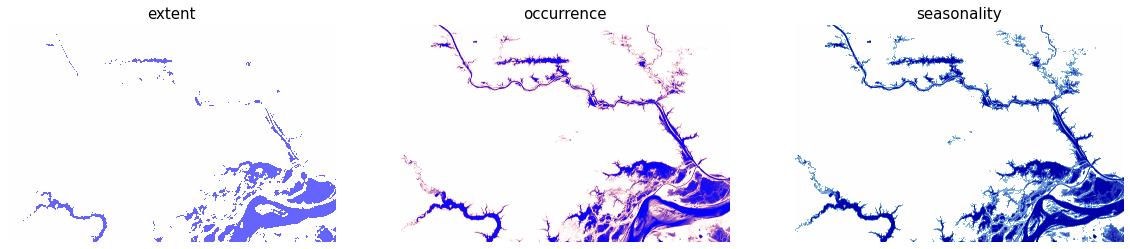

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))

for i, asset_key in enumerate(assets_of_interest):
    ax[i].imshow(data.sel(band=asset_key), norm=Normalize(0, 255), cmap=cmaps[asset_key])
    ax[i].set_title(asset_key, fontdict={"fontsize": 15})
    ax[i].set_axis_off()

plt.show()

## Proximity Distance

The [xrspatial.proximity](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Distance) function takes a values aggregate as its input and computes a new distance aggregate. This computation is based on a set of target values and a specific distance metric (`EUCLIDEAN`, `MANHATTAN`, or `GREAT_CIRCLE`). The `proximity` function uses this distance metric to calculate the distance at each array cell (pixel) in the values aggregate from the nearest of the target points. This smallest distance is set as each cell's value in the returned aggregate.

A powerful feature of `proximity` is that you have the option to use the `target_values` parameter to target specific points inside the aggregate for distance calculation and ignore the rest. By default, all non-zero pixels are set as targets.

Use the `proximity` function to calculate the proximity distance for the dataset's Maximum Water Extent asset using the default Euclidean distance metric. By default, all non-zero pixels will be used as targets.

In [8]:
extent_data = data.sel(band="extent")
extent_data.name = "Water Extent"

extent_proximity = proximity(extent_data)
extent_proximity.name = 'Water Extent proximity distance'

In [9]:
# helper function to plot images
def plot_imgs(asset_data, asset_cmap, proximity_data, proximity_cmap, proximity_norm=None):    
    fig = plt.figure(frameon=False, figsize=(15, 10))
    
    fig.add_subplot(121)
    plt.axis('off')    
    plt.imshow(asset_data, norm=Normalize(0, 255), cmap=asset_cmap)
    plt.title(asset_data.name)
    
    fig.add_subplot(122)
    plt.axis('off')        
    plt.imshow(proximity_data, norm=proximity_norm, cmap=proximity_cmap)
    plt.imshow(asset_data, norm=Normalize(0, 255), cmap=asset_cmap, alpha=0.5)
    plt.title(proximity_data.name)
    
    plt.show() 

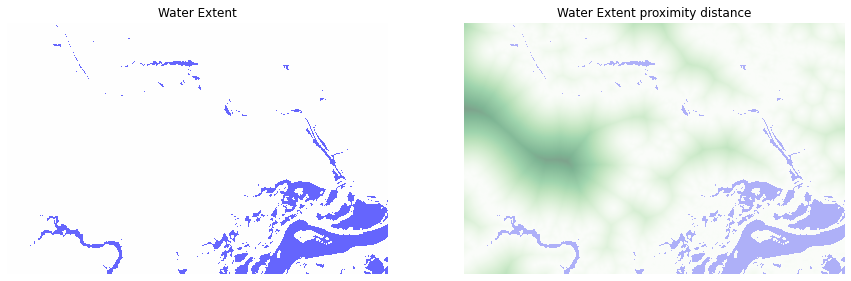

In [10]:
plot_imgs(
    asset_data=extent_data,
    asset_cmap=cmaps["extent"],
    proximity_data=extent_proximity,
    proximity_cmap="Greens"
)

In this visualization, dark green points are points that are further away from surface water, while lighter points are closer to surface water.

## Proximity Allocation

Similar to `xrspatial.proximity`, the [xrspatial.allocation](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Allocation) function takes an aggregate as its input and finds the smallest distance from each cell to any one of the target points or source points. However, instead of returning the distance, the `allocation` function returns the value at that source point and sets the current cell to that value. The result is a raster with block areas where all cells in each area are set to the value of that area's nearest source.

Like `proximity`, `allocation` also accepts a `target_values` parameter to define the target points. Use the `allocation` function with the dataset's Occurrence Water Extent data. This time, use the Great Circle distance metric but still keep all target points active by not using the `target_values` parameter.

In [11]:
occurrence_data = data.sel(band="occurrence")
occurrence_data.name = "Water Occurrence"

occurrence_allocation = allocation(
    occurrence_data,
    distance_metric='GREAT_CIRCLE'
)
occurrence_allocation.name = 'Water Occurrence proximity allocation'

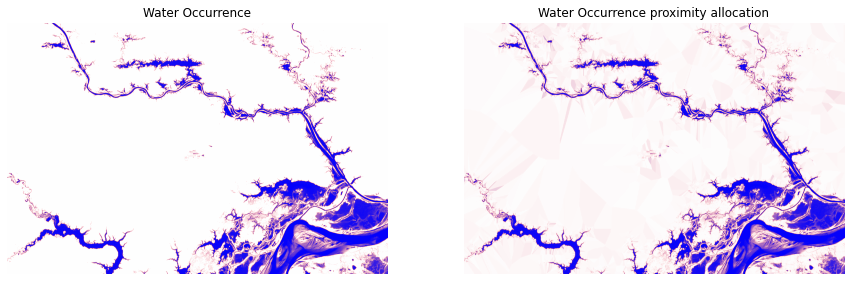

In [12]:
plot_imgs(
    asset_data=occurrence_data,
    asset_cmap=cmaps["occurrence"],
    proximity_data=occurrence_allocation,
    proximity_cmap=cmaps["occurrence"],
    proximity_norm=Normalize(0, 255),    
)

Notice the blocks in the visualization: each of the differently shaded blocks contains all of the points that share the target point in the center as their nearest target point.

## Proximity Direction

Once again, similar to `xrspatial.proximity`, the [xrspatial.direction](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Direction) function begins by calculating the smallest distance for each cell to a source point. Instead of returning the distance to that point, the `direction` function returns the direction in degrees to that nearest source point. The output values range from 0 to 360:
- 0 is for the source cell itself
- 90 is East
- 180 is South
- 270 is West
- 360 is North

Use the `direction` function to calculate the proximity direction of areas that have at least ten months of water occurrence based on the dataset's Water Seasonality data.

This time, set `target_values` to `[10, 11, 12]` to calculate directions from pixels with a value of 10, 11, or 12. These values represent the number of months that surface water is present in that area. Use the Manhattan distance metric in this example.

In [13]:
seasonality_direction = direction(
    data.sel(band="seasonality"),
    distance_metric='MANHATTAN',
    target_values=[10, 11, 12]
)        

seasonality_direction.name = '10-12 months Water Seasonality proximity direction'

To better visualization all targets, filter out non-target pixels:

In [15]:
# for display purpose only
selected_seasonality = copy.deepcopy(data.sel(band="seasonality"))
selected_seasonality.data[selected_seasonality.data < 10] = 0
selected_seasonality.name = 'Water Seasonality (10-12 months)'

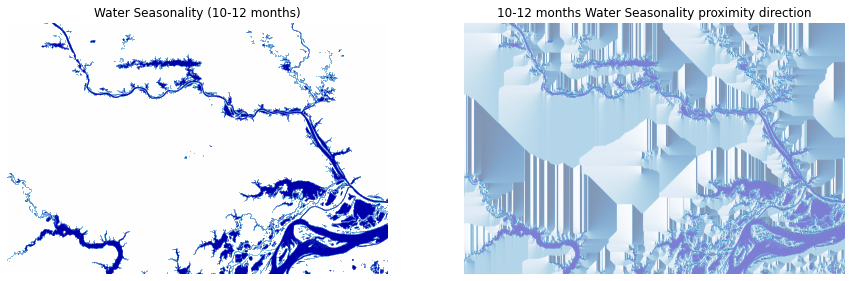

In [16]:
plot_imgs(
    asset_data=selected_seasonality,
    asset_cmap=cmaps["seasonality"],
    proximity_data=seasonality_direction,
    proximity_cmap="Blues"
)

## Next steps